In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Dataset

In [3]:
#Abbiamo 1797 campioni, ciascuno 8x8. Ogni immagine è organizzata come un vettore di 64 pixel
digits_dataset = load_digits()

print(digits_dataset.data.shape)

(1797, 64)


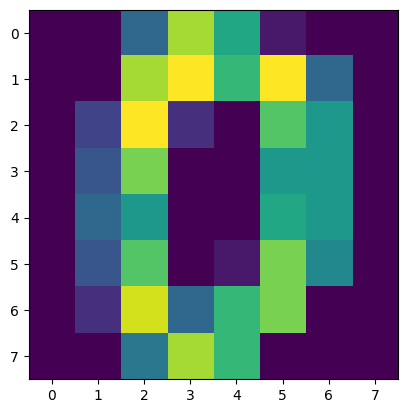

In [4]:
from matplotlib import pyplot as plt
#ogni riga è una immagine. Vediamo un esempio
img1 = digits_dataset.data[0]
#facciamo il reshape del vettore di 64 elementi in 8x8
img1 = np.reshape(img1, (8,8))
plt.imshow(img1)


In [5]:
#essendo ogni riga una immagine allora prendo le prime 1000 come training set, 350 come validation set e il resto come test set
training_data = digits_dataset.data[0:1000].astype(np.float32)
validation_data = digits_dataset.data[1000:1350].astype(np.float32)
test_data = digits_dataset.data[1350:].astype(np.float32)

Non alleneremo la rete dandole tutti i dati, ma batch dopo batch. Creiamo quindi un DataLoader che semplicemente dividerà i dati in batch da 64 immagini (dopo averli mischiati) e ci restituirà, quando richiesto, un batch alla volta.

In [6]:
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# Model

In [59]:
class MaskedConvolutionalLayer(nn.Module):
   def __init__(self,A,num_canali_input,num_filters, kernel_size,padding="same",**kwargs):
    super(MaskedConvolutionalLayer, self).__init__()
    
    #se siamo nel primo layer (A=true) o meno
    self.A = A
    
    #creo un classico Conv2D con padding="same", stride=1 e filtri num_filters
    self.conv2d = nn.Conv2d(in_channels=num_canali_input, out_channels=num_filters,kernel_size=kernel_size,padding=padding)
    
    #Maschero il filtro 
    #1. Ottengo la shape (N,N) del kernel
    kernel_shape = self.conv2d.kernel_size
    #2. Creo una maschera (N,N) di zeri
    mask = torch.zeros(kernel_shape)
    #Inserisco 1 dalla prima riga fino a metà del kernel (divisione intera)
    mask[: kernel_shape[0] // 2]=1.0
    #Inserisco 1 dalla prima colonna fino a metà. Se è di tipo A non considero
    #il centro, altrimenti lo includo
    mask[kernel_shape[0] // 2,: kernel_shape[1] // 2 + (not A) ]=1.0

    #modifico il kernel
    self.conv2d.weight.data = self.conv2d.weight.data * mask
   
   def forward(self,x):
      return self.conv2d(x)
    

In [60]:
class ResidualBlock(nn.Module):
  def __init__(self,num_canali_input,number_of_filters,**kwargs):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=num_canali_input,out_channels=number_of_filters//2,kernel_size=1)
    self.relu = nn.ReLU(inplace=True)
    self.masked_conv = MaskedConvolutionalLayer(False,num_canali_input=number_of_filters//2,num_filters=number_of_filters//2, kernel_size=3)
    self.conv2 =nn.Conv2d(in_channels=number_of_filters//2,out_channels=number_of_filters,kernel_size=1)

  def forward(self,input):
    
    x = self.conv1(input)

    x = self.relu(x)

    x = self.masked_conv(x)

    x = self.conv2(x)

    #implemento la skip connection semplicemente sommando l'input all'output x
    return x + input


In [75]:
class PixelCNN(nn.Module):
  def __init__(self,num_canali_input,num_canali_output,**kwargs):
    super(PixelCNN, self).__init__()
    
    self.num_canali_input = num_canali_input
    self.num_canali_output = num_canali_output

    #il primo layer di convoluzione non deve considerare il pixel centrale
    self.masked_conv_A = MaskedConvolutionalLayer(True,num_canali_input,num_filters=128, kernel_size=7)

    #gli ultimi due layer di convoluzione non deve considerare il pixel centrale e deve avere kernel 1 e padding="valid"
    self.masked_conv_B = MaskedConvolutionalLayer(False,num_canali_input=128,num_filters=128, kernel_size=1, padding="valid")
    
    self.relu = nn.ReLU(inplace=True)

    #residual block
    self.residual_block = ResidualBlock(num_canali_input=128,number_of_filters=128)

    #output. Il kernel deve avere 17 output rappresentati le 17 probabilità per i 17 valori (per ogni pixel)
    self.output_layer = nn.Conv2d(in_channels=128,out_channels=num_canali_output, kernel_size=1, padding="valid")

  def forward(self, input, mode="training"):
    x = self.masked_conv_A(input)

    x = self.relu(x)

    for i in range(5):
      x = self.residual_block(x)
    
    for i in range(2):
      x = self.masked_conv_B(x)
    
    output = self.output_layer(x)
    output = output.permute(0,2,3,1)

    output = torch.softmax(output, dim=3)

    if mode=="prediction":
      return output

    EPS = 1.e-5
    x_one_hot = F.one_hot(input.long(), num_classes=self.num_canali_output) .squeeze()
    log_p = x_one_hot * torch.log(torch.clamp(output, EPS, 1. - EPS))
    vector_of_probabilities_per_image = torch.sum(log_p, dim=-1) 
    mle_per_image = -vector_of_probabilities_per_image.sum(dim=(1,2))
    mle_loss_batch = mle_per_image.mean()

    return mle_loss_batch


In [76]:
model = PixelCNN(1,17)

# Training

In [77]:
learning_rate = 0.002
#i parametri che l'optimizer deve ottimizzare sono tutti quelli del modello
parameters_to_optimize = [p for p in model.parameters() if p.requires_grad == True]

optimizer = torch.optim.Adamax(parameters_to_optimize, lr=learning_rate)

In [ ]:
import copy 

best_validation_loss = 1000000

patience = 0
max_patience = 20
number_of_epochs = 1000

for epoch in range(number_of_epochs):
  model.train()
  print("Epoca "+str(epoch)+" _____________________________________________________________________")

  for index_batch, batch in enumerate(training_loader):
    #il batch ha shape 64x64. Portiamolo in (64,1,64), ossia 64 immagini ciascuna con
    # un canale e 64 pixel
    batch = batch.unsqueeze(1)
    #stavolta manipoliamo immagini bidimensionali invece che "immagini flattate"
    batch = batch.reshape(batch.size(0), batch.size(1),8,8)
    #ottengo la loss sul batch corrente
    loss = model.forward(batch)

    #calcolo le derivate parziali della loss rispetto ogni parametro
    loss.backward()

    #adesso ogni parametro ha in .grad il gradiente. Aggiorno il suo valore
    optimizer.step()

    #resetto il .grad di ogni parametro (altrimenti sommo quello attuale al successivo che calcoleremo nell'epoca dopo)
    optimizer.zero_grad()

    print("   Loss: ", loss)

  #alla fine di ogni epoca, valuto come si comporta la loss col validation set
  print("   ___________________________")
  model.eval()
  validation_loss = 0
  N = 0
  for index_batch, batch in enumerate(validation_loader):
    batch = batch.unsqueeze(1)
    batch = batch.reshape(batch.size(0), batch.size(1),8,8)
    loss_i = model.forward(batch)
    validation_loss = validation_loss + loss_i
    N = N +  1

  validation_loss = validation_loss/N
  print("   Loss media validation: "+str(validation_loss))

  #se tale modello ha una loss migliore di quella attualmente migliore..
  if validation_loss < best_validation_loss:
    patience = 0
    best_validation_loss = validation_loss
    print("   la loss risulta essere migliore")
    #best_model = copy.deepcopy(model)
  else:
    print("   patience= "+ str(patience+1))
    patience = patience + 1
  
  if patience > max_patience:
    print("")
    print("Patience massimo superato. Fine del training")
    break


# Sampling

In [109]:
def generate():
  generated_image = torch.zeros((1,1,8,8))
  batch,channels, rows, cols = generated_image.shape
  for row in range(rows):
    for col in range(cols):
      for channel in range(channels): #utile per rgb
        #calcolo i vettori di probabilità ma prendo solo quel vettore (di 17)
        #del pixel (row,col)
        probs = model.forward(generated_image, mode="prediction")[:, row, col, :]
        pixel_value = torch.multinomial(probs, num_samples=1)
        generated_image[:, row, col, channel] = pixel_value
    return generated_image

def generete_image():
  generated_image = generate()
  return generated_image


In [ ]:
generete_image()